In [ ]:
import os
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()

#normalizing
x_train = x_train/255
x_test = x_test/255

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
data_folder = r'/content/drive/MyDrive/DLS/hw4/'

In [ ]:
def image_to_patches(images, patch_size=7):

    num_patches = images.shape[1] // patch_size
    patches = tf.image.extract_patches(
        images=tf.expand_dims(images, -1),
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )

    # Flatten the patches and reshape
    patches = tf.reshape(patches, [images.shape[0], num_patches * num_patches, -1])
    return patches

In [ ]:
# Convert images to patches
train_patches = image_to_patches(x_train)
test_patches = image_to_patches(x_test)

In [ ]:
print('Train Patches Shape:',train_patches.shape)
print('Test Patches Shape:',test_patches.shape)

Train Patches Shape: (60000, 16, 49)
Test Patches Shape: (10000, 16, 49)


In [ ]:
# Create sequences for RNN
# Input sequences (first 15 patches)
x_train_seq = train_patches[:, :15, :]
x_test_seq = test_patches[:, :15, :]

# Target sequences (last 15 patches)
y_train_seq = train_patches[:, 1:, :]
y_test_seq = test_patches[:, 1:, :]

# Check shapes
print(f'Train Input Shape: {x_train_seq.shape}')
print(f'Train Target Shape: {y_train_seq.shape}')
print(f'Test Input Shape: {x_test_seq.shape}')
print(f'Test Target Shape: {y_test_seq.shape}')

Train Input Shape: (60000, 15, 49)
Train Target Shape: (60000, 15, 49)
Test Input Shape: (10000, 15, 49)
Test Target Shape: (10000, 15, 49)


In [ ]:
def create_generative_rnn(inference=False):

    #using functional API
    input_layer = tf.keras.layers.Input(shape=(None, 49))

    # Inputs for the states of each LSTM layer
    initial_h1 =  tf.keras.layers.Input(shape=(64,))
    initial_c1 =  tf.keras.layers.Input(shape=(64,))
    initial_h2 =  tf.keras.layers.Input(shape=(64,))
    initial_c2 =  tf.keras.layers.Input(shape=(64,))

    lstm1, state_h1, state_c1 = tf.keras.layers.LSTM(64, return_sequences=True, return_state=True)(input_layer, initial_state=[initial_h1, initial_c1])
    lstm2, state_h2, state_c2 = tf.keras.layers.LSTM(64, return_sequences=True, return_state=True)(lstm1,initial_state=[initial_h2, initial_c2])
    dense_output = tf.keras.layers.Dense(49, activation='sigmoid')(lstm2)

    if inference:
        outputs = [dense_output,state_h1,state_c1, state_h2, state_c2]
    else:
        outputs = dense_output

    generative_rnn = tf.keras.models.Model(inputs=[input_layer, initial_h1, initial_c1, initial_h2, initial_c2], outputs=outputs)

    return generative_rnn

generative_rnn_tr = create_generative_rnn(inference=False)
generative_rnn_tr.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),loss='mean_squared_error')

generative_rnn_tr.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_67 (InputLayer)       [(None, None, 49)]           0         []                            
                                                                                                  
 input_68 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 input_69 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 lstm_36 (LSTM)              [(None, None, 64),           29184     ['input_67[0][0]',            
                              (None, 64),                            'input_68[0][0]',     

In [ ]:
# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

def initial_states(size):
    # Initialize initial states as zeros
    initial_h1_train = np.zeros((size, 64))
    initial_c1_train = np.zeros((size, 64))
    initial_h2_train = np.zeros((size, 64))
    initial_c2_train = np.zeros((size, 64))

    return initial_h1_train,initial_c1_train,initial_h2_train,initial_c2_train

initial_h1_train,initial_c1_train,initial_h2_train,initial_c2_train = initial_states(x_train_seq.shape[0])
initial_h1_test,initial_c1_test,initial_h2_test,initial_c2_test = initial_states(x_test_seq.shape[0])

# Train the model
generative_rnn_his = generative_rnn_tr.fit([x_train_seq,initial_h1_train,initial_c1_train, initial_h2_train,initial_c2_train],y_train_seq,
                                        epochs=200, batch_size=100,
                                        validation_data=([x_test_seq, initial_h1_test,initial_c1_test,initial_h2_test,initial_c2_test], y_test_seq),
                                        callbacks=[early_stopping])

Epoch 1/200
600/600 [==============================] - 39s 59ms/step - loss: 0.1477 - val_loss: 0.1230
Epoch 2/200
600/600 [==============================] - 32s 54ms/step - loss: 0.1143 - val_loss: 0.1089
Epoch 3/200
600/600 [==============================] - 33s 54ms/step - loss: 0.0988 - val_loss: 0.0894
Epoch 4/200
600/600 [==============================] - 33s 55ms/step - loss: 0.0835 - val_loss: 0.0801
Epoch 5/200
600/600 [==============================] - 36s 60ms/step - loss: 0.0771 - val_loss: 0.0752
Epoch 6/200
600/600 [==============================] - 33s 54ms/step - loss: 0.0729 - val_loss: 0.0715
Epoch 7/200
600/600 [==============================] - 33s 54ms/step - loss: 0.0695 - val_loss: 0.0680
Epoch 8/200
600/600 [==============================] - 33s 55ms/step - loss: 0.0662 - val_loss: 0.0648
Epoch 9/200
600/600 [==============================] - 36s 60ms/step - loss: 0.0633 - val_loss: 0.0621
Epoch 10/200
600/600 [==============================] - 33s 54ms/step - l

In [ ]:
data_folder = r'/content/drive/MyDrive/DLS/hw4/'
generative_rnn_tr.save_weights(data_folder+'generative_rnn.h5')

In [ ]:
def generate_bottom_half(model, data):
    generated_images = []
    original_images = []
    for img_set in data:
        for image in img_set:
            top_half = image[:8]  # Get the top half patches
            bottom_half = image[8:]  # Get the bottom half patches for comparison

            # Initialize the LSTM states
            h1 = np.zeros((1, 64))
            c1 = np.zeros((1, 64))
            h2 = np.zeros((1, 64))
            c2 = np.zeros((1, 64))

            # Generate patches for the bottom half
            for patch_idx in range(8):
                input_patch = np.expand_dims(top_half if patch_idx == 0 else generated_patches[-1],axis=0)
                #predict next patch
                preds, h1, c1,h2,c2 = model.predict([input_patch, h1, c1,h2,c2],verbose=0)

                #take last patch
                generated_patch = preds[:,-1:, :]

                if patch_idx == 0:
                    generated_patches = generated_patch
                else:
                    generated_patches = np.vstack([generated_patches, generated_patch])

            # Combine the known top half and the generated bottom half
            full_image_patches = np.vstack([top_half, np.squeeze(generated_patches,axis=1)])

            generated_images.append(full_image_patches)
            original_images.append(np.vstack([top_half, bottom_half]))

    return generated_images, original_images

In [ ]:
num_samples = 10
#get 10 samples for each digit from 0 to 9
data_by_class = []
for digit in range(10):
    indices = np.where(y_test == digit)[0]
    class_images = np.array(test_patches)[indices][:num_samples]  # Select 'num_samples' images for this class
    data_by_class.append((class_images))

In [ ]:
#create model for predicting bottom half
generative_rnn_inf = create_generative_rnn(inference=True)

generative_rnn_inf.set_weights(generative_rnn_tr.get_weights())

In [ ]:
#generate bottom half
generated_images, original_images = generate_bottom_half(generative_rnn_inf, data_by_class)

In [ ]:
def reconstruct_from_patches(patches, original_shape=(28,28), patch_size=7):

    num_images, num_patches, _ = patches.shape
    num_patches_per_dim = int(original_shape[1] // patch_size)

    # Initialize an empty tensor for the reconstructed image
    reconstructed = np.zeros((num_images, original_shape[0], original_shape[1]))

    # Iterate over each patch and place it in the correct position
    for i in range(num_patches_per_dim):
        for j in range(num_patches_per_dim):
            patch_idx = i * num_patches_per_dim + j
            patch = patches[:, patch_idx, :]
            patch = tf.reshape(patch, (num_images, patch_size, patch_size))
            reconstructed[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patch

    return np.squeeze(reconstructed,axis=0)

In [ ]:
import matplotlib.gridspec as gridspec

def plot_generated_vs_original(generated_images, original_images, num_classes=10, num_samples=10):
    # Create a large figure to hold all the subplots
    fig = plt.figure(figsize=(18, 6))
    outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0)

     # Create the title for the generated images subplot
    ax = plt.Subplot(fig, outer[0])
    ax.set_title('Generated Images', fontsize=16)
    ax.axis('off')
    fig.add_subplot(ax)

    # Plot the generated images
    inner = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=outer[0],
                                             wspace=0.1, hspace=0.05)

    for i in range(num_classes):
        for j in range(num_samples):

            ax = plt.Subplot(fig, inner[i,j])
            fig.add_subplot(ax)

            generated_image = generated_images[i * num_samples + j]
            generated_image = reconstruct_from_patches(np.expand_dims(generated_image,axis=0))
            ax.imshow(generated_image, cmap='gray')
            ax.axis('off')

     # Create the title for the original images subplot
    ax = plt.Subplot(fig, outer[1])
    ax.set_title('Original Images', fontsize=16)
    ax.axis('off')
    fig.add_subplot(ax)
    inner = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=outer[1],
                                             wspace=0.1, hspace=0.05)

    # Plot the original images
    for i in range(num_classes):
        for j in range(num_samples):
            ax = plt.Subplot(fig, inner[i,j])
            fig.add_subplot(ax)

            original_image = original_images[i * num_samples + j]
            original_image = reconstruct_from_patches(np.expand_dims(original_image,axis=0))
            ax.imshow(original_image, cmap='gray')
            ax.axis('off')

    plt.show()

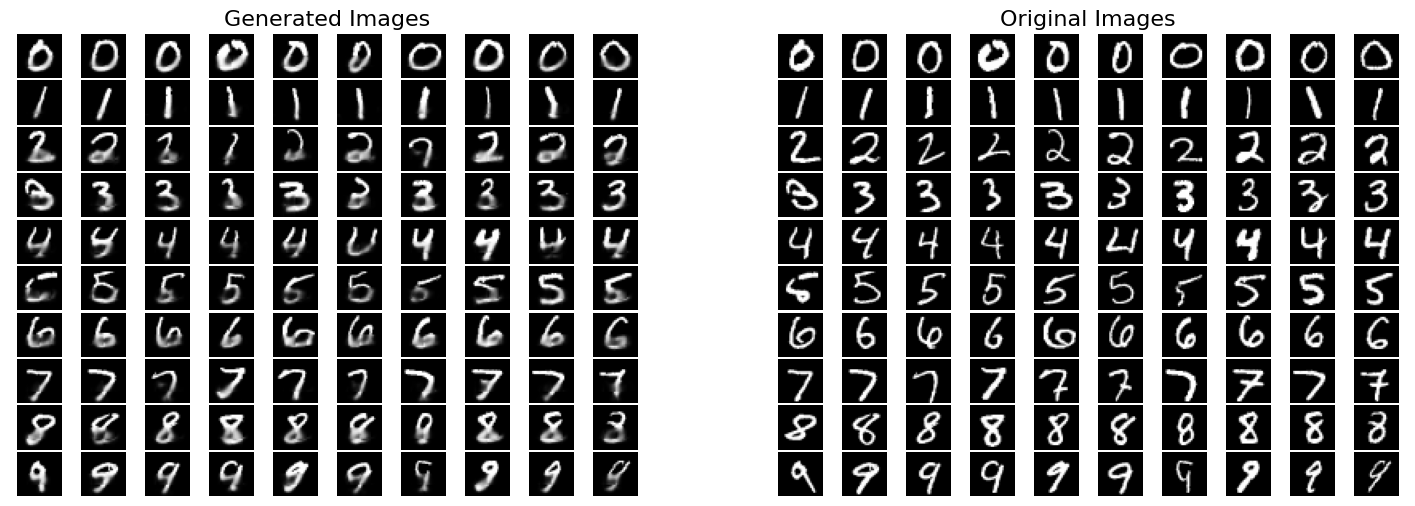

In [ ]:
plot_generated_vs_original(generated_images, original_images)

### Discussion:
- We can see that the model predicted next patch almost correctly for all images except for few such as 2 (for some, it generated 3, 7 and 1 patches because of variations in the first half similar to those numbers), and last image of 8 as 3(as first half is not completely closed).Apart from those, it generated quite good results.